In [33]:
import os
import numpy as np
import keras
import tensorflow as tf
import tweepy
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
import math
import nltk
import csv
import sklearn
import plotly.offline as py 
import plotly.graph_objs as go
import datetime
import tweepy
import textblob
import json

from math import sqrt
from matplotlib import pyplot
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
from sklearn.metrics import mean_squared_error
from textblob import TextBlob
from nltk.corpus import stopwords
from __future__ import print_function
from pandas import DataFrame
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download('stopwords')

py.init_notebook_mode(connected = True)
%matplotlib inline
#os.getcwd()

### Section 1 Tweet Cleanup  ###

In [5]:
consumer_key=''
consumer_secret=''
access_token=''
access_token_secret=''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

name = "elonmusk"

my_list_of_dicts = []    
with open('tweetresults.txt', 'w') as file:
    tweets = tweepy.Cursor(api.user_timeline, screen_name = name).items(5000)
    for each_json_tweet in tweets:
        my_list_of_dicts.append(each_json_tweet._json)
    file.write(json.dumps(my_list_of_dicts, indent = 4)) 
    

In [2]:
my_demo_list = []
with open('tweetresults.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        my_demo_list.append({'Text': str(text),
                             'Likes': int(favorite_count),
                             'Retweet': int(retweet_count),
                             'Date': created_at,
                             'Length': len(text)
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = 
                                  ['Text', 
                                   'Likes', 'Retweet', 
                                   'Date',
                                  'Length'])

In [3]:
(tweet_json.head(5))

,Text,Likes,Retweet,Date,Length
0,@scottwww @cleantechnica Could be worse 😇,831,48,Tue Oct 02 06:10:29 +0000 2018,41
1,@incentives101 @cleantechnica Tesla Autopilot ...,1062,89,Tue Oct 02 06:07:45 +0000 2018,140
2,RT @SpaceX: We ❤️ @NASA! You have inspired and...,0,3757,Tue Oct 02 03:45:24 +0000 2018,140
3,@cleantechnica Something especially weird goin...,7547,516,Tue Oct 02 03:44:46 +0000 2018,140
4,Naughty by Nature 😉\nhttps://t.co/muZdxJWjyZ,25124,2807,Mon Oct 01 08:22:30 +0000 2018,43


In [10]:
# Data Cleanse #
tweet_json['Text'] = tweet_json['Text'].str.replace(r'http\S+', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('RT @[\w]*', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('&gt', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace("[^a-zA-Z#]", " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace("www", " ", case=False)

In [11]:
# Test - Remove words < 3 characters (to remove stop words)#
tweet_json2 = tweet_json.copy()
tweet_json2['CText'] = tweet_json2['Text'].apply(lambda x: ' '.join([w for w in x.split() if
                                                           len(w)>3]))

In [12]:
#Tokenizer#
tokens = tweet_json2['CText'].apply(lambda x: x.split())
tokens.head()

0                 [scott, cleantechnica, Could, worse]
1    [incentives, cleantechnica, Tesla, Autopilot, ...
2    [NASA, have, inspired, shown, world, believe, ...
3    [cleantechnica, Something, especially, weird, ...
4                                    [Naughty, Nature]
Name: CText, dtype: object

In [13]:
tweet_json2.tail()

,Text,Likes,Retweet,Date,Length,CText
3224,Survey shows Tesla owners in Germany unders...,0,571,Thu Nov 10 18:56:14 +0000 2016,126,Survey shows Tesla owners Germany understand m...
3225,Trump Picks Top Climate Skeptic to Lead EPA...,0,3984,Thu Nov 10 00:22:18 +0000 2016,94,Trump Picks Climate Skeptic Lead Transition
3226,Model X wins the Golden Steering Wheel,0,1036,Tue Nov 08 22:01:10 +0000 2016,81,Model wins Golden Steering Wheel
3227,Tesla Advanced Automation Germany to make o...,0,1125,Tue Nov 08 14:57:23 +0000 2016,140,Tesla Advanced Automation Germany make factori...
3228,InLucidReverie a bit like that but hopefully...,304,27,Mon Nov 07 09:58:00 +0000 2016,80,InLucidReverie like that hopefully more meanin...


In [14]:
#Remove common words + stop words - NLTK #
# play, player, played, plays --> play #
stop_words = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokens = tokens.apply(lambda x: [stemmer.stem(i)
                                         for i in x])

for i in range(len(tokens)):
    tokens[i] = ' '.join(tokens[i])

tokens2 = []
for w in tokens:
    if w not in stop_words:
        tokens2.append(w)
        
tweet_json2['Tokens'] = tokens
tweet_json2['Text'].replace('', np.nan, inplace=True)
tweet_json2.dropna(subset=['Text'], inplace=True)
tweet_json2['Date'] = pd.to_datetime(tweet_json2['Date']).dt.date
tweet_json2.head()

,Text,Likes,Retweet,Date,Length,CText,Tokens
0,scott cleantechnica Could be worse,831,48,2018-10-02,41,scott cleantechnica Could worse,scott cleantechnica could wors
1,incentives cleantechnica Tesla Autopilot ...,1062,89,2018-10-02,140,incentives cleantechnica Tesla Autopilot team ...,incent cleantechnica tesla autopilot team awes...
2,We NASA You have inspired and shown th...,0,3757,2018-10-02,140,NASA have inspired shown world believe impossi...,nasa have inspir shown world believ imposs pos...
3,cleantechnica Something especially weird goin...,7547,516,2018-10-02,140,cleantechnica Something especially weird going...,cleantechnica someth especi weird go with yaho...
4,Naughty by Nature,25124,2807,2018-10-01,43,Naughty Nature,naughti natur


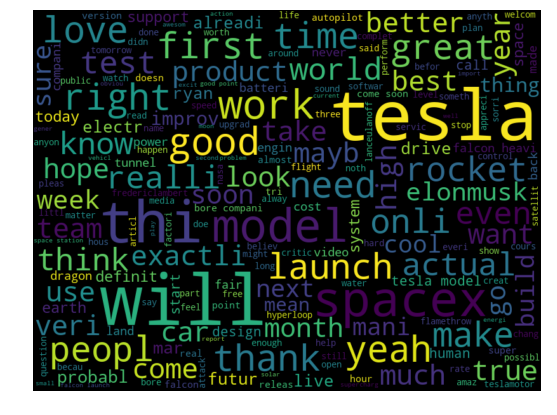

In [15]:
all_words = ' '.join([text for text in tweet_json2['Tokens']])
wordcloud = WordCloud(width=800, 
                      height=600, 
                      random_state=21, 
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
## Text Blob - Sentiment Analysis (polarity) ##
def sentiment(x):
    sentValue = TextBlob(x)
    return sentValue.sentiment.polarity

tweet_json2['sentiment'] = tweet_json2['Text'].apply(sentiment)

conditions = [
    (tweet_json2['sentiment'] > 0 ),
    (tweet_json2['sentiment'] < 0),
    (tweet_json2['sentiment'] == 0)]

choices = ['positive', 'negative', 'neutral']
tweet_json2['Pol_Name'] = np.select(conditions, choices, default=' ')
#tweet_json2

In [17]:
#Total Stats#
print('total tweets', len(tweet_json2))
print('positive tweets', sum(tweet_json2['Pol_Name'] == 'positive')/len(tweet_json2)*100, '%')
print('negative tweets', sum(tweet_json2['Pol_Name'] == 'negative')/len(tweet_json2)*100, '%')
print('neutral tweets',sum(tweet_json2['Pol_Name'] == 'neutral')/len(tweet_json2)*100, '%')

total tweets 3229
positive tweets 43.57386187674203 %
negative tweets 15.174976772994736 %
neutral tweets 41.25116135026324 %


### Section 2 - LSTM Stock Analysis ###

In [18]:
# Stock Prices Nov 2016 - Present #
tesla = pd.read_csv('TSLA.csv')
tesla.Date = pd.to_datetime(tesla.Date)
Prices = tesla[['Date', 'Close', 'Volume']].copy()
#Prices

In [30]:
# Average Sentiment - Multiple Tweets Per Day #
sent = tweet_json2[['Date', 'sentiment']].copy()
sent['Date'] = pd.to_datetime(sent['Date'], errors='coerce')
sent = sent.resample('D', on='Date')['sentiment'].sum()
sent = pd.DataFrame({'Date':sent.index, 'sentiment':sent.values})

print(len(sent))
print(len(Prices))
Prices.Date = pd.to_datetime(Prices.Date)
s1 = pd.merge(Prices, sent, how='left', on=['Date'])
s1['sentiment'].replace(np.nan, 0, inplace=True)
s1.set_index('Date', inplace = True)

695
477


In [37]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
values = s1.values.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)

In [39]:
reframed.drop(reframed.columns[[-1,-2]], axis = 1, inplace = True)

In [41]:
# Train/Test Split #
train_size = int(len(s1) * .7)
test_size = len(s1) - train_size

values = reframed.values
train = values[0:train_size, :]
test = values[train_size:len(values), :]

trainX, trainY = train[:, :-1], train[:, -1]
testX, testY = test[:, :-1], test[:, -1]

trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(333, 1, 3) (333,) (143, 1, 3) (143,)


In [44]:
layers = [100,55,1]

def create_model(stateful):
    model = Sequential()
    
    model.add(LSTM(
        units = layers[0],
        input_shape=(trainX.shape[1], trainX.shape[2]),
        return_sequences = True,
        stateful = stateful 
    ))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        units=layers[1], 
        return_sequences = True,
        stateful = stateful
    ))        
    model.add(Dropout(0.3))

#     model.add(LSTM(
#         units=layers[2],
#         return_sequences = True,    
#         stateful = stateful
#     ))
    model.add(Flatten())
    
    model.add(Dense(
        units = layers[2],
        activation = 'linear'))
    
    model.compile(loss = 'mae', optimizer = 'adam')   
    return model

print('Created LSTM Model.')
model_stateful = create_model(stateful = False)

Created LSTM Model.


In [46]:
epochs = 200
batch_size = 40
mod1 = model_stateful.fit(trainX,trainY,batch_size,epochs,verbose=0, validation_data=(testX, testY),shuffle=False)

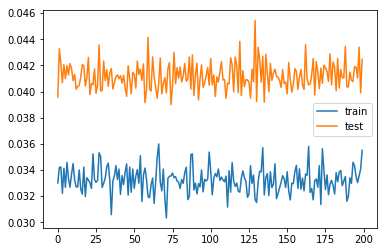

In [47]:
## Loss Plots ##
pyplot.plot(mod1.history['loss'], label = 'train')
pyplot.plot(mod1.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

In [48]:
# Predict on Train and Test # 
trainPredict = model_stateful.predict(trainX, batch_size = batch_size)
rmse_train = sqrt(mean_squared_error(trainPredict, trainY))
print('Train RMSE: %.3f' % rmse_train)

testPredict = model_stateful.predict(testX, batch_size = batch_size)
rmse_test = sqrt(mean_squared_error(testPredict, testY))
print('Test RMSE: %.3f' % rmse_test)

Train RMSE: 0.034
Test RMSE: 0.057


In [49]:
# Reshape Data Train/Test #
trainX2 = trainX.reshape((trainX.shape[0], trainX.shape[2]))
inv_trainY = np.concatenate((trainPredict, trainX2[:,1:]), axis = 1)
inv_trainY = scaler.inverse_transform(inv_trainY)
inv_trainY = inv_trainY[:,0]

#Predicted
testX2 = testX.reshape((testX.shape[0], testX.shape[2]))

inv_testY = np.concatenate((testPredict, testX2[:,1:]), axis = 1)
inv_testY = scaler.inverse_transform(inv_testY)
inv_testY = inv_testY[:,0]

#Actual TestY
actualY = testY.reshape((len(testY), 1))

actual_testY = np.concatenate((actualY, testX2[:,1:]), axis = 1)
actual_testY = scaler.inverse_transform(actual_testY)
actual_testY = actual_testY[:,0]


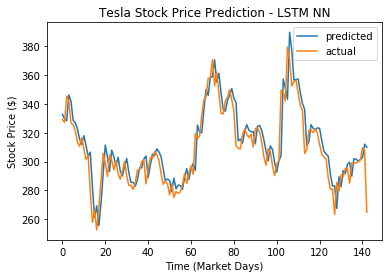

In [62]:
df3 = s1[['Close', 'sentiment']]

## Loss Plots ##
pyplot.plot(inv_testY, label = 'predicted')
pyplot.plot(actual_testY, label = 'actual')
pyplot.legend()
pyplot.ylabel('Stock Price ($)')
pyplot.xlabel('Time (Market Days)')
pyplot.title('Tesla Stock Price Prediction - LSTM NN')
pyplot.show()